# This notebook is for the Fair-Shapely experiment

In [13]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [15]:
from src.data.unified_dataloader import load_dataset

a, processed_german_credit = load_dataset('german_credit')
_, processed_adult = load_dataset('adult')

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [16]:
processed_adult.head(3)

,age,education-num,capital-gain,capital-loss,hours-per-week,sex,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income
0,0.030671,1.134739,0.148453,-0.21666,-0.035429,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0.837109,1.134739,-0.145920,-0.21666,-2.222153,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-0.042642,-0.420060,-0.145920,-0.21666,-0.035429,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


### 3. Split label/unlabel data, split train/test data.

In [24]:
'''UCI dataset'''
df = processed_adult.copy()
X = df.drop('income', axis=1)
y = df['income']



# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (22792, 106)
X_test shape: (9769, 106)


### 4. Train the original model

In [25]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8749104309550619


In [26]:
X_train['sex'].value_counts()

sex
1    15292
0     7500
Name: count, dtype: int64

In [27]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 1
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 0
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]


In [28]:
# male_condition = X_train['sex'] == 1
# X_train_majority = X_train[male_condition]
# y_train_majority = y_train[male_condition]

# female_condition = X_train['sex'] == 0
# X_train_minority = X_train[female_condition]
# y_train_minority = y_train[female_condition]

# # 获取 X_train_minority 和 y_train_minority 的第一行
# first_row_X_train_minority = X_train_minority.iloc[0:1]
# first_row_y_train_minority = y_train_minority.iloc[0:1]

# # 将第一行添加到 X_train_majority 和 y_train_majority
# X_train_majority = pd.concat([X_train_majority, first_row_X_train_minority])
# y_train_majority = pd.concat([y_train_majority, first_row_y_train_minority])

### 5. Evaluate the performance of original model

In [30]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')

original_test_DR: 0.03856540843844414
original_train_DR: 0.038255129009485245


In [31]:
# from fairlearn.metrics import MetricFrame, selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate,count
# metrics = {'accuracy': accuracy_score,
#            'selection_rate': selection_rate,
#            'false_positive_rate': false_positive_rate,
#            'true_positive_rate': true_positive_rate,
#            'false_negative_rate': false_negative_rate,
#            'true_negative_rate': true_negative_rate,
#               'count': count}
# a_test = X_test['sex']
# mf_original = MetricFrame(metrics=metrics,
#                  y_true=y_test,
#                  y_pred=y_pred,
#                  sensitive_features=a_test)

# print("Test set fairness metrics (before mitigation):")
# mf_original.by_group.plot(
#     kind="bar",
#     subplots=True,
#     layout=[3, 3],
#     legend=False,
#     figsize=[12, 8],
#     colormap="Accent",
#     title="Baseline--train_limited_labeled_data",
# )
# diff = mf_original.by_group


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

2. 初始化FairnessExplainer
--------接下来先对minority group进行修改--------
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用fairshap, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用fairshap, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
在X_train_minority中shapely value中大于0.1的值的个数有: 188
--------接下来对majority group进行修改--------
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
在X_train_majority中shapely value中大于0.1的值的个数有: 1005
6. 开始整理minority部分的修改和majority部分的修改并且合并新数据,共修改1193个数据点, 使用new training set训练新模型


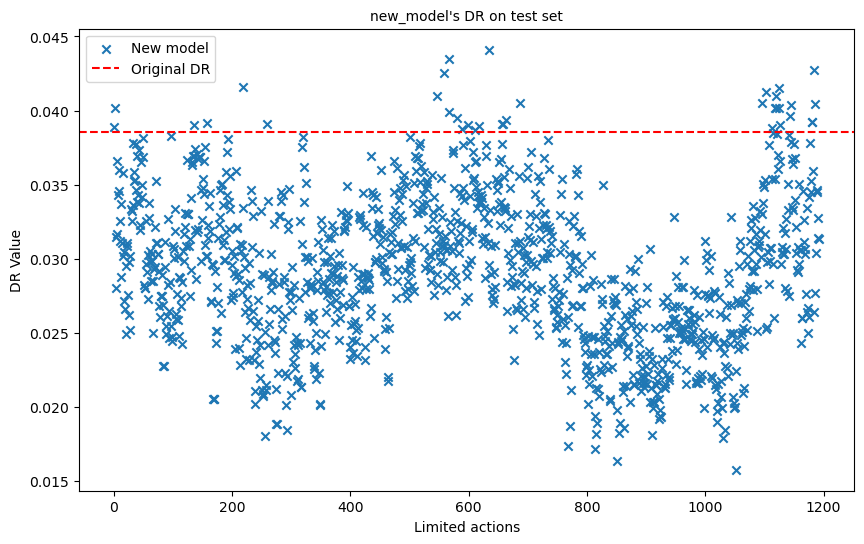

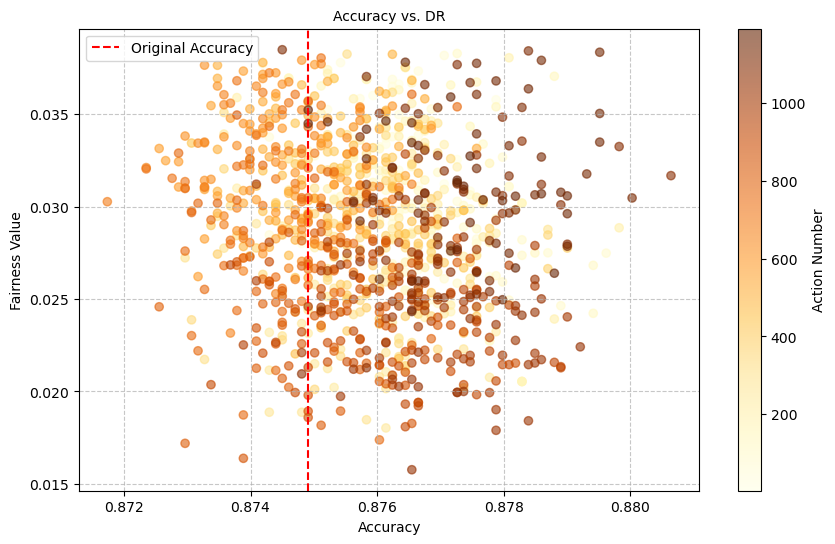

([0.038883984,
  0.04016815,
  0.031434916,
  0.027999355,
  0.036623247,
  0.031669166,
  0.034291357,
  0.034560412,
  0.036005393,
  0.032544456,
  0.031225853,
  0.028788831,
  0.03370634,
  0.03108563,
  0.03020694,
  0.035777777,
  0.0304388,
  0.027159005,
  0.026589097,
  0.029504446,
  0.024893176,
  0.031093284,
  0.030834178,
  0.027533878,
  0.026212597,
  0.029777534,
  0.030155828,
  0.02516793,
  0.033371486,
  0.033232085,
  0.032527033,
  0.037785124,
  0.033643033,
  0.035839166,
  0.035245124,
  0.035329334,
  0.037722096,
  0.034658786,
  0.036931947,
  0.033852153,
  0.034315392,
  0.033776604,
  0.037330844,
  0.03225815,
  0.031965885,
  0.036505476,
  0.034171123,
  0.034973476,
  0.036877457,
  0.038174327,
  0.028242024,
  0.027999105,
  0.02799881,
  0.032562766,
  0.029652968,
  0.02907718,
  0.027273383,
  0.030281616,
  0.032741364,
  0.03376077,
  0.030536303,
  0.02979369,
  0.0284658,
  0.030310405,
  0.029881557,
  0.024962382,
  0.02852773,
  0.029340

In [32]:
from src.experiments_approach4 import ExperimentNew4

''' 改变minority group中的部分特征值'''

experiment = ExperimentNew4(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='adult')
experiment.run_experiment()

2. 初始化FairnessExplainer
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
shapely value中大于0.1的值的个数有: 61
shapely value中大于0.1的值的个数有: 107


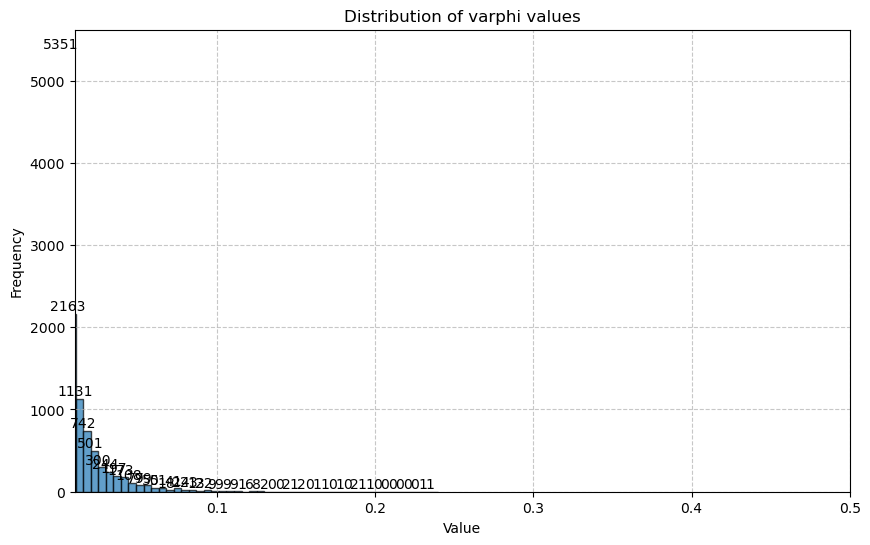

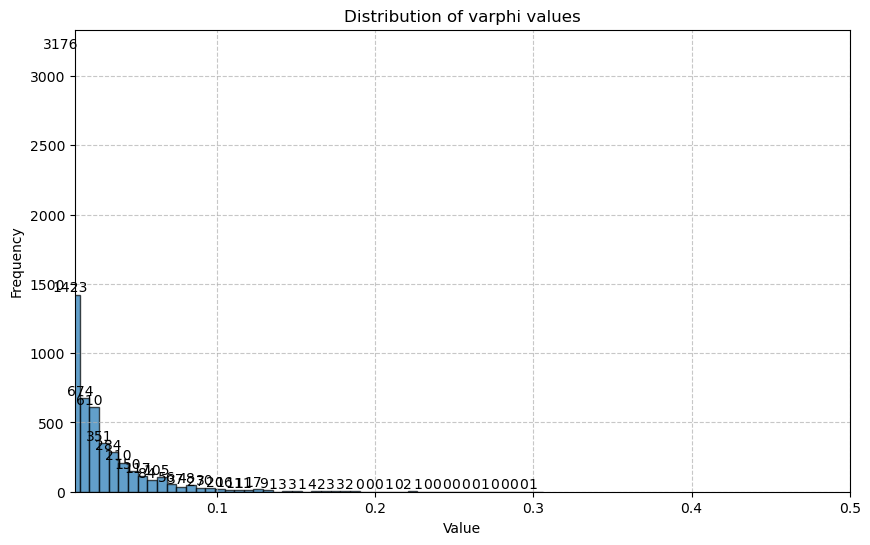

6. 开始整理并且合并新数据,共修改168个数据点, 使用new training set训练新模型
changed_value_info.shape: 167


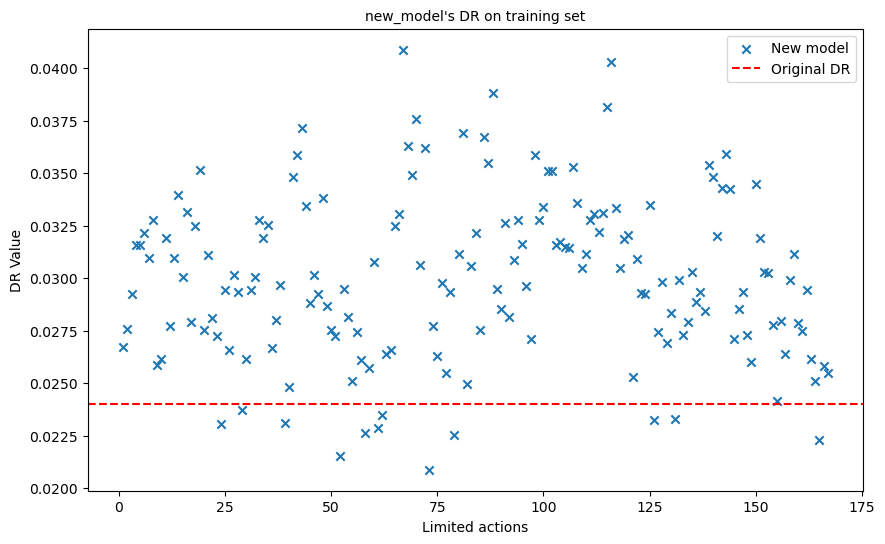

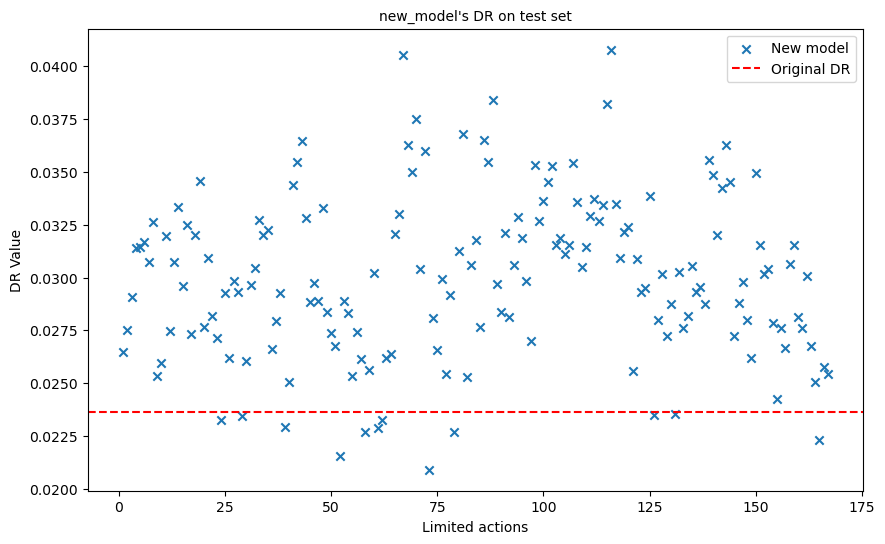

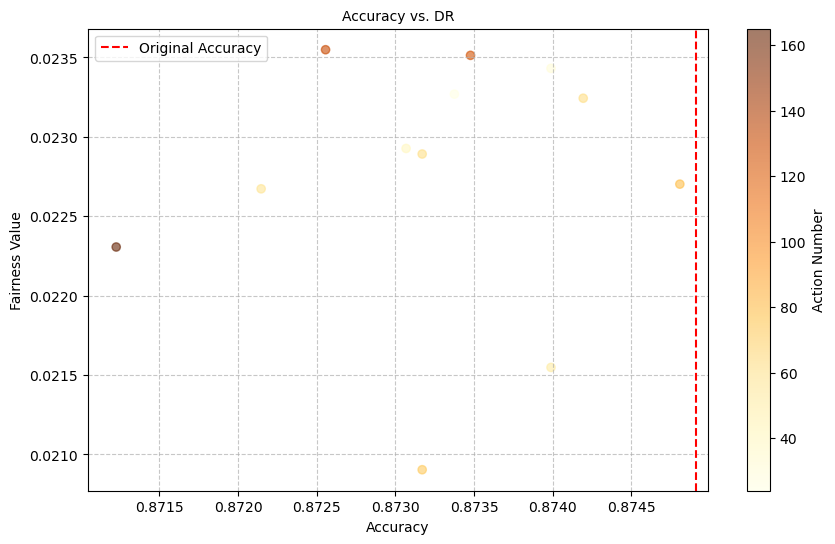

([0.02647943,
  0.027520638,
  0.029065436,
  0.031383906,
  0.031425174,
  0.03169024,
  0.03073371,
  0.032620013,
  0.025335602,
  0.02597389,
  0.031946823,
  0.027493063,
  0.030724617,
  0.0333396,
  0.029612863,
  0.032494586,
  0.02733937,
  0.03201274,
  0.03459251,
  0.027657147,
  0.030935034,
  0.028161805,
  0.027145056,
  0.023268702,
  0.029255005,
  0.026177783,
  0.029821098,
  0.029293308,
  0.02343106,
  0.026041606,
  0.02962516,
  0.030442985,
  0.032711834,
  0.03199895,
  0.03226786,
  0.02664104,
  0.027947191,
  0.029255904,
  0.022926712,
  0.025075352,
  0.03438538,
  0.035484828,
  0.036484607,
  0.03282434,
  0.028829345,
  0.029765366,
  0.028885536,
  0.033299875,
  0.028378224,
  0.027353102,
  0.026761333,
  0.021547917,
  0.02889478,
  0.028326198,
  0.025334654,
  0.027441531,
  0.026126074,
  0.022672502,
  0.025613876,
  0.030213408,
  0.022891672,
  0.02324298,
  0.026203023,
  0.026365703,
  0.03207599,
  0.033017475,
  0.04055057,
  0.036257196,


In [13]:
''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew2(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='adult',
                            change_group = 'majority')
experiment2.run_experiment()